<a href="https://colab.research.google.com/github/davidho27941/ML_tutorial_notebook/blob/main/Build_model_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基於TesnorFlow平台的基本模型建立
---
## 載入必要函式庫以及資料集

為了在`TensorFlow`建立模型，我們需要導入以下函式庫：

* tensorflow 
* tensorflow-datasets

以及常用的資料處理函式庫：

* Numpy 
* Pandas

我們可以透過`tf.config.list_physical_devices('GPU')`來確認GPU是否可用，並選擇在CPU或是GPU上運行我們的程式。

In [2]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## 匯入MNIST資料集

在此範例中，我們一樣會使用MNIST資料集進行示範。
在載入時，我們需要使用`tensorflow-datasets`的`tfds.load()`函式來抽取MNSIT資料集。並利用經由`tf.data.Dataset`的`map()`方法對資料集進行轉置；最後，我們設定批次數量為64。

我們將分別導入訓練資料集以及測試資料集作為訓練以及測試使用。

In [3]:
train_ds, train_ds_info = tfds.load(name="mnist", 
                    split='train', 
                    with_info=True, 
                    as_supervised=True)

test_ds, test_ds_info = tfds.load(name="mnist", 
                    split='test', 
                    with_info=True, 
                    as_supervised=True)

def preprocess(x, y):
    x = x/255
    x = tf.reshape(x, [784])

    y = tf.one_hot(y, 10)  
    return x, y

train_ds = train_ds.map(lambda x, y: preprocess(x, y)).batch(64)
test_ds = test_ds.map(lambda x, y: preprocess(x, y)).batch(64)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


---
## 建立順序式模型

在`TensorFlow`之中，建立順序是模型可以透過`tf.kears.Sequential()`函式來進行。主要有兩種作作法。

1. 先行建立`model`物件，並透過`model.add()`方法為模型添加結構。
2. 利用`tf.kears.Sequential`建立模型時，直接在參數內填入模型結構。

### 方法一

In [4]:
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.InputLayer(input_shape=(784)))
model_1.add(tf.keras.layers.Dense(128, activation='relu'))
model_1.add(tf.keras.layers.Dense(64, activation='relu'))
model_1.add(tf.keras.layers.Dense(10, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


### 方法二

In [4]:
model_2 = tf.keras.Sequential([
                             tf.keras.layers.InputLayer(input_shape=(784)), 
                             tf.keras.layers.Dense(128, activation='relu'), 
                             tf.keras.layers.Dense(64, activation='relu'), 
                             tf.keras.layers.Dense(10, activation='softmax'),
                            ])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


---
## 設定各項超參數、損失函數以及優化器



In [9]:
EPOCHS = 20 #@param {type:"slider", min:1, max:100, setp: 1}
LR = 1e-2 #@param {type:"number"}
OPTIMIZER = "adam" #@param ["adam", "SGD"]
LOSS_FN = "binary_crossentropy" #@param ["binary_crossentropy", "categorical_crossentropy"]

if OPTIMIZER == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate = LR)
elif OPTIMIZER == 'SGD':
    momentum = 0.4 #@param {type:"slider", min:0, max:1, step:0.1}
    optimizer = tf.keras.optimizers.SGD(learning_rate = LR, 
                                        momentum = momentum)


---
## 進行訓練

在建立模型，並設定好超參數以及優化器之後，我們可以利用`model.compile()`對模型進行編譯，並利用`model.fit()`進行訓練。

### 編譯模型

在模型建立之後，我們必須利用`model.compile()`對模型的優化器、損失函數以及評估量尺等選項進行設定。

需要設定的選項如下：

* 優化器（optimizer）
* 損失函數（loss function）
* 評估量尺（metrics）

可選設定如下：
* 損失函數權重（loss weights）
* 權重矩陣（weighted metrics）
* 除錯模式（run_eagerly）

> 更多選項可以至[官方文件](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)了解

In [6]:
model_1.compile(loss = LOSS_FN, 
                optimizer = optimizer, 
                metrics=['acc'])

---
### 進行訓練

當模型編譯完成後，我們就可以開始進行訓練。訓練的方式為利用`model.fit()`函數搭配相關的參數進行訓練。`model.fit()`在訓練結束後，將會回傳一個帶有訓練歷史資訊的物件，我們可以建立一個`history`變數用以儲存回傳值，並在後續對訓練過程進行了解。

必要的參數有：

* 輸入資料以及標籤（x, y）
* 批次內資料數量（batch_size）
* 週期數量（epochs）
* 顯示模式（verbose）

> 資料輸入的形式以及設定可以參照我們先前的[介紹](https://hackmd.io/@davidho9713/HyfHBzcxY/%2F86N1lvF2SdaRkcnuuWeJTg)。

可選設定如下：
* 回測函式（callbacks）
* 驗證資料集以及標籤（validation_data）
* 驗證比例（validation_split）

> 更多的選項可至[官方文件](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)查閱。


In [7]:
history = model_1.fit(train_ds, 
            epochs = EPOCHS, 
            verbose = 1)

Epoch 1/20
938/938 [==============================] - 29s 25ms/step - loss: 0.0420 - acc: 0.9302
Epoch 2/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0226 - acc: 0.9651
Epoch 3/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0187 - acc: 0.9713
Epoch 4/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0166 - acc: 0.9752
Epoch 5/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0154 - acc: 0.9769
Epoch 6/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0137 - acc: 0.9798
Epoch 7/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0130 - acc: 0.9805
Epoch 8/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0121 - acc: 0.9821
Epoch 9/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0113 - acc: 0.9834
Epoch 10/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0111 - acc: 0.9843
Epoch 11/20
938/938 [==========================

---
## 查看學習曲線

在上一個部份，我們對模型進行了訓練，並取得了一個帶有模型訓練資訊的`history`變數。我們可以先透過內建的`__dict__`方法查看`history`物件下帶有哪些資訊。

In [8]:
print(f"Type of history: {type(history)}")

history.__dict__

Type of history: <class 'keras.callbacks.History'>


{'_chief_worker_only': None,
 '_supports_tf_logs': False,
 'epoch': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19],
 'history': {'acc': [0.9301999807357788,
   0.96506667137146,
   0.9713000059127808,
   0.9752166867256165,
   0.9768666625022888,
   0.9797833561897278,
   0.9805333614349365,
   0.9821000099182129,
   0.9833666682243347,
   0.984250009059906,
   0.9850999712944031,
   0.9861999750137329,
   0.9874333143234253,
   0.986549973487854,
   0.9869499802589417,
   0.9876000285148621,
   0.9884666800498962,
   0.9891166687011719,
   0.9893166422843933,
   0.9896666407585144],
  'loss': [0.0420457124710083,
   0.022628113627433777,
   0.018658721819519997,
   0.016573892906308174,
   0.015381831675767899,
   0.013715801760554314,
   0.013027049601078033,
   0.01208391785621643,
   0.01126111950725317,
   0.011059775948524475,
   0.01021718978881836,
   0.009544560685753822,
   0.009200699627399445,
   0.00950317550450

由上方的執行結果，我們可以得知幾項資訊：

1. `history`變數為`keras.callbacks.History`物件，並非字典物件。雖然可以利用`__dict__`方法將內部資料以字典方式來輸出，但並無法利用字典物件所具有的`.keys()`、`.values()`以及`.items()`方法來提取資訊。

2. `history`變數下的`history`分枝儲存了以下重要資訊：

    * `acc`
    * `loss`

接下來我們將利用`acc`以及`loss`資訊來作圖，顯示訓練中的準確率以及損失值變化。

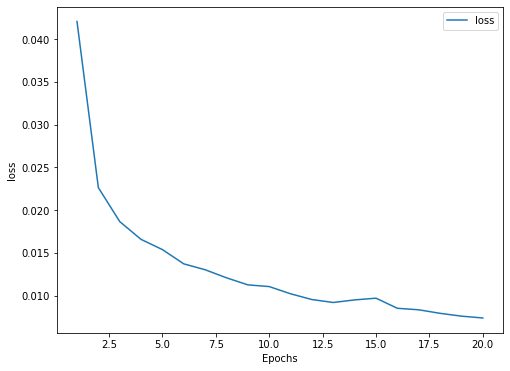

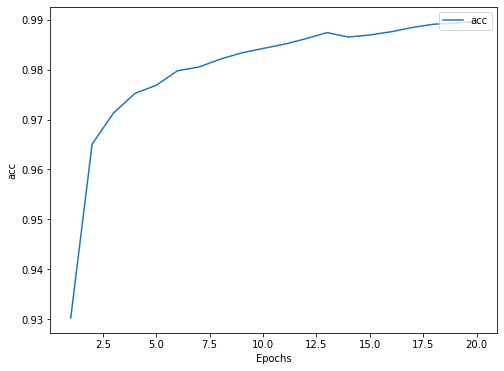

In [9]:
import matplotlib.pyplot as plt

x = [i for i in range(1, EPOCHS+1)]
plt.figure(figsize=(8,6))
plt.plot(x, history.history['loss'], label='loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x, history.history['acc'], label='acc')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.show()


---
## 利用Functional API 建立自定義模型

先前的部份中，我們介紹了如何利用`tf.keras.Sequential`建立順序式模型。對於機器學習專案，常態下我們需要建立各式各樣的自訂模型結構。例如`ResNet-50`中所利用的殘差連結（Shortcut connection/Residual connection）就是一種無法利用順序式模型來建立的結構。我們將在此章節示範如何利用`Functional API`建立自定義的模型結構。

> 本章將不會實作殘差連結。有興趣者可以參閱此[介紹](https://medium.com/@hupinwei/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-resnet%E4%B9%8B%E6%AE%98%E5%B7%AE%E5%AD%B8%E7%BF%92-f3ac36701b2f)

`Functional API`是一個由`Keras`套件所提供的實作方法，可以讓我們以更加彈性的方式建立我們所希望的模型結構。無論是非線性拓樸，或是共享層以及多重輸入/輸出都可以藉由`Functional API`來實踐。

參考我們在先前所建立的順序式模型，如果我們要利用`Functional API`來建立相同的模型，要如何來達成呢？且看以下範例。

In [10]:
# 建立輸入層
inputs = tf.keras.layers.Input(shape=(784))

# 建立全連結層
dense_1 = tf.keras.layers.Dense(128, activation='relu')(inputs)
dense_2 = tf.keras.layers.Dense(64, activation='relu')(dense_1)
outputs = tf.keras.layers.Dense(10, activation='softmax')(dense_2)


# 封裝模型
model = tf.keras.Model(inputs = inputs, 
                       outputs = outputs, 
                       name='functional_api_model')

model.summary()

Model: "functional_api_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


在上方的範例中，我們於第二行利用`tf.keras.Input`函式建立了模型的輸入點，用以承接導入模型的資料；從第五行開始，我們建立了一系列的全連結層。

利用`Functional API`建立模型時最大的不同在於，我們將會在每一層的設定時，額外於行末利用括號宣告將會輸入的資料。以第五行為例：

```
dense_1 = tf.keras.layers.Dense(128, activation='relu')(inputs)
```
在`Dense`函數的後方，與以往不同的多出了一個`(inputs)`，這寫法的意義在於，告知`Functional API`，本層的輸入函數為`inputs`所輸出的結果。我們可以在第六行以及第七行發現相同的寫法。

在完成模型結構的建構後，最重要的一步就是將模型進行封裝。在順序式模型中，因為具有明確的順序關係，`Sequential`函式將會自動封裝整個模型。在利用`Functional API`建構的模型中，我們必須自行宣告模型的輸入以及輸出，並利用`tf.keras.Model`函式對模型進行封裝。

## 編譯並進行訓練

在完成對模型的封裝以後，我們就可以利用與先前相同的方法，對模型進行編譯以及訓練。

In [11]:
model.compile(loss = LOSS_FN, 
                optimizer = optimizer, 
                metrics=['acc'])

history = model.fit(train_ds, 
            epochs = EPOCHS, 
            verbose = 1)

Epoch 1/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0598 - acc: 0.8998
Epoch 2/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0343 - acc: 0.9441
Epoch 3/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0289 - acc: 0.9528
Epoch 4/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0262 - acc: 0.9581
Epoch 5/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0242 - acc: 0.9617
Epoch 6/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0227 - acc: 0.9639
Epoch 7/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0216 - acc: 0.9656
Epoch 8/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0202 - acc: 0.9678
Epoch 9/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0197 - acc: 0.9682
Epoch 10/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0192 - acc: 0.9694
Epoch 11/20
938/938 [============================

同樣的，我們也能用`.fit()`函式回傳的模型訓練資料進行作圖，並顯示訓練中的準確度以及損失值變化。

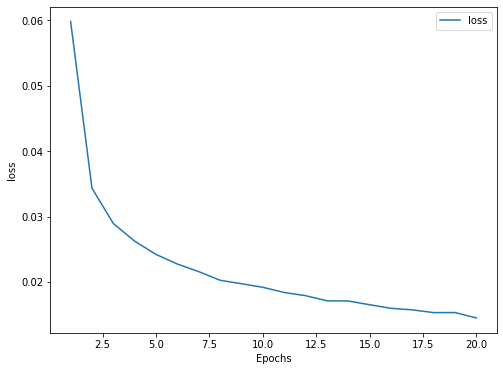

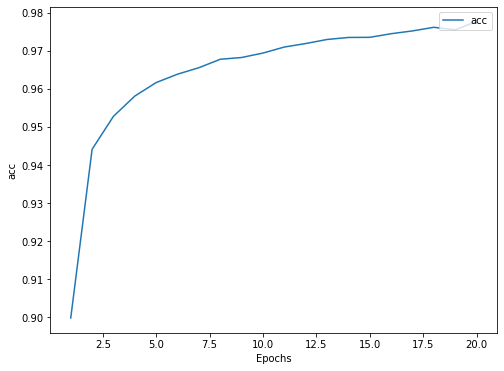

In [12]:
import matplotlib.pyplot as plt

x = [i for i in range(1, EPOCHS+1)]
plt.figure(figsize=(8,6))
plt.plot(x, history.history['loss'], label='loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x, history.history['acc'], label='acc')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.show()


---
## 利用自定義類別建立模型

在先前的部份，我們嘗試利用`Functional API`建立自訂結構的模型。但在此之上，我們還能有更加彈性的選擇，那就是利用繼承了`tf.keras.Model`類別來進行模型的建立。此方法有幾個必要的元素：

1. 一個繼承了`tf.keras.Model`的類別。
2. 類別內必須實作`__init__`以及`call`兩個方法。
3. 類別必須利用`spuer().__init__()`方法繼承`tf.keras.Model`的初始化設定。

以下是利用此方法建立模型的範例。我們將使用與先前相同的模型結構來進行示範。

### 模型設定


In [5]:
class MLP_MODEL(tf.keras.Model):
    def __init__(self, **kargs):
        super(MLP_MODEL, self).__init__(**kargs)
        self.dense_1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense_3 = tf.keras.layers.Dense(10, activation='softmax')
    def call(self, inputs):
        y = self.dense_1(inputs)
        y = self.dense_2(y)
        outputs = self.dense_3(y)
        return outputs

model = MLP_MODEL()

以上這種方法，又稱`模型子類化(model subclassing)`。有別於先前的建立模式，利用這種方式所建立的模型不需要經由`model.compile`函式進行編譯，也不需要利用`model.fit()`進行訓練。利用此方法建立的模型將具有更大的自由度以及更加彈性的架構。相對的，其編寫、訓練以及設定上也將更加複雜。

### 設定損失函數以及優化器

In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.CategoricalAccuracy(name='train_acc')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.CategoricalAccuracy(name='test_acc')

### 設定訓練以及測試流程

透過`模型子類化`建立的模型，需要利用`tf.GradientTape`函式來進行訓練；梯度的計算，模型的優化則透過先前建立的`loss_object`、`optimizer`以及相對應的`metrics`物件進行處理。

In [13]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        pred = model(images, training=True)
        loss = loss_object(labels, pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, pred)

@tf.function
def test_step(images, labels):
    test_pred = model(images, training=False)
    test_losses = loss_object(labels, test_pred)

    test_loss(test_losses)
    test_acc(labels, test_pred)

### 進行訓練以及測試



In [14]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_acc.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_acc.result() * 100}'
    )

Epoch 1, Loss: 0.10257095098495483, Accuracy: 97.24166107177734, Test Loss: 0.1258823424577713, Test Accuracy: 96.86000061035156
Epoch 2, Loss: 0.09232383221387863, Accuracy: 97.52833557128906, Test Loss: 0.1455402821302414, Test Accuracy: 96.68000030517578
Epoch 3, Loss: 0.09847172349691391, Accuracy: 97.39666748046875, Test Loss: 0.15411247313022614, Test Accuracy: 96.55000305175781
Epoch 4, Loss: 0.0830605998635292, Accuracy: 97.76166534423828, Test Loss: 0.15152032673358917, Test Accuracy: 96.80000305175781
Epoch 5, Loss: 0.08318177610635757, Accuracy: 97.80332946777344, Test Loss: 0.15016533434391022, Test Accuracy: 96.76000213623047
Epoch 6, Loss: 0.07981283962726593, Accuracy: 97.91667175292969, Test Loss: 0.15467844903469086, Test Accuracy: 96.81999969482422
Epoch 7, Loss: 0.07160687446594238, Accuracy: 98.11000061035156, Test Loss: 0.13336355984210968, Test Accuracy: 97.05999755859375
Epoch 8, Loss: 0.07107507437467575, Accuracy: 98.13833618164062, Test Loss: 0.191660836338996

## 結語

在本範例中，我們示範了如何用`tf.keras.Sequential()`函數以及利用`Functional API`來建立一個簡單的機器學習模型。接下來我們將了解如何透過建立`Callback`物件以及利用`Tensorboard`來監控模型的訓練流程。